# Congestion control algorithm

## Run experiments

In [1]:
import sem
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Create our SEM campaign
ns_3_dir = '../../../../'
script = 'congestion-example'
results_dir = 'results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=False,
                                   optimized=False, skip_configuration=True)


In [2]:
def compute_area(rings, range=2426.85):
    disc = (range / 1000)**2 * np.pi

    if (rings == 1):
        return disc

    radius = range * np.cos(np.pi / 6)
    ngateways = 3 * rings * rings - 3 * rings + 1

    hexag = range / 1000 * radius / 1000 * 3
    # internal hexagons area + vertices area + sides area
    return (ngateways - 6 * (rings - 1)) * hexag + 3 * (hexag + disc) + 2 * (rings - 2) * (2 * hexag + disc)


In [3]:
# density for device position
int(np.rint(10 * compute_area(2))) / compute_area(1)


63.07178399089293

In [8]:
# Define the parameter space we are interested in exploring
rings = 2
params = {
    "devices": int(np.rint(63.07178399089293 * compute_area(rings))),
    "periods": 0.1,
    "file": True,
    "sir": "CROCE",
    "rings": rings
}
runs = 1

# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)


Running simulations: 100%|██████████| 1/1 [00:06<00:00,  6.89s/simulation]


## Device positions, per SF

In [5]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['X Position [m]', 'Y Position [m]', 'SF'])
def get_device_position_sf (result):
    """
    Extract the position and SF of each device from deviceStatus.txt
    """
    df = pd.read_csv(StringIO(result['output']['deviceStatus.txt']), sep=" ", header=None)
    df.columns = ['time','id','xpos','ypos','zpos','gwdist','dr','txpow','sent','received','devOT','aggDC','cluster']
    df['sf'] = 12 - df['dr'].to_numpy()
    return df[['xpos','ypos','sf']].to_numpy().tolist()

In [9]:
results = campaign.get_results_as_dataframe(get_device_position_sf,
                                            params=params,
                                            parallel_parsing=True)
results['SF'] = results['SF'].astype(int)
results

,devices,periods,file,sir,rings,change,variance,clusters,save,congest,...,remove,sampling,range,fast,initSF,beta,RngRun,X Position [m],Y Position [m],SF
0,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,-910.702,543.439,7
1,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,1087.340,3174.110,8
2,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,5248.210,-2274.300,9
3,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,2694.930,-333.189,11
4,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,-2047.420,-1317.350,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7356,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,5909.850,1844.760,12
7357,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,2113.720,3351.280,11
7358,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,-183.021,2093.130,12
7359,7361,0.1,True,CROCE,2,False,0.0,0.0,False,None,...,0.001,1.0,2.0,None,0.95,2426.85,30,-3430.040,-2850.650,7


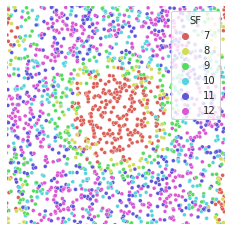

In [27]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFpositionV2'

lim = 2700
pal = sns.color_palette('hls', 6)
g = sns.scatterplot(data=results, x='X Position [m]', y='Y Position [m]', hue="SF", palette=pal, s=15)
g.set (xlim=(-lim,lim), ylim=(-lim,lim))
g.axes.set_box_aspect(1)
g.axis('off')
sns.move_legend(g, "upper right")
plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat), bbox_inches='tight')
plt.show()

## SF distribution

In [5]:
@sem.utils.yields_multiple_results
@sem.utils.output_labels(['Distance [m]', 'SF'])
def get_device_distance_sf(result):
    """
    Extract the position and SF of each device from deviceStatus.txt
    """
    df = pd.read_csv(
        StringIO(result['output']['deviceStatus.txt']), sep=" ", header=None)
    df.columns = ['time', 'id', 'xpos', 'ypos', 'zpos', 'gwdist',
                  'dr', 'txpow', 'sent', 'received', 'devOT', 'aggDC', 'cluster']
    df['sf'] = 12 - df['dr'].to_numpy()
    return df[['gwdist', 'sf']].to_numpy().tolist()


In [10]:
results = campaign.get_results_as_dataframe(get_device_distance_sf,
                                            params=params,
                                            parallel_parsing=True)
results['SF'] = results['SF'].astype(int)
results


,devices,periods,file,sir,rings,change,variance,clusters,save,congest,...,load,remove,sampling,range,fast,initSF,beta,RngRun,Distance [m],SF
0,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,15,1205.400,7
1,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,15,1983.260,12
2,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,15,1829.540,10
3,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,15,1171.200,9
4,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,15,1354.410,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700285,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,23,911.612,7
700286,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,23,2083.290,12
700287,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,23,2338.190,11
700288,23343,0.1,True,CROCE,2,0.0,0.01,None,None,False,...,None,0.0,2.0,2426.85,False,True,1.0,23,2024.080,10


In [11]:
df = results.groupby('SF')['devices'].count().reset_index()
df['Percentage (%)'] = 100 * df['devices'] / df['devices'].sum()
df


,SF,devices,Percentage (%)
0,7,150892,21.547073
1,8,58233,8.315555
2,9,80970,11.562353
3,10,112187,16.020077
4,11,128648,18.370675
5,12,169360,24.184267


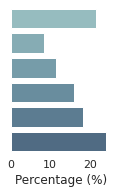

In [39]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFpercentage'

gold = (1 + 5 ** 0.5) / 2
w = 1.8
sns.set_theme (style='white', rc={'figure.figsize': (w, w*gold - 0.2)})
g = sns.barplot(data=df, x='Percentage (%)', y='SF',
                palette=sns.cubehelix_palette(10, rot=-.25, light=.7), orient='h')
g.set(yticklabels=[])
g.set(ylabel=None)
g.axes.tick_params(axis='x', which='major', pad=-1)
sns.despine(bottom = True, left = True)
plt.savefig('{0}/{1}.{2}'.format(plots_dir, filename,
            fileformat), bbox_inches='tight')
plt.show()


/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/alle/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


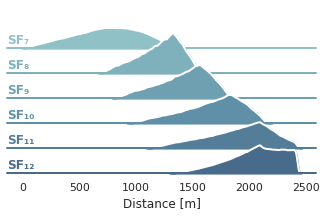

In [41]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFdistance'

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(results, row="SF", hue="SF", aspect=10, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Distance [m]",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=True)
g.map(sns.kdeplot, "Distance [m]", clip_on=False, color="w", lw=2, bw_adjust=.5, common_norm=True)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, 'SF' + label.translate(SUB), fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Distance [m]")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat), bbox_inches='tight')

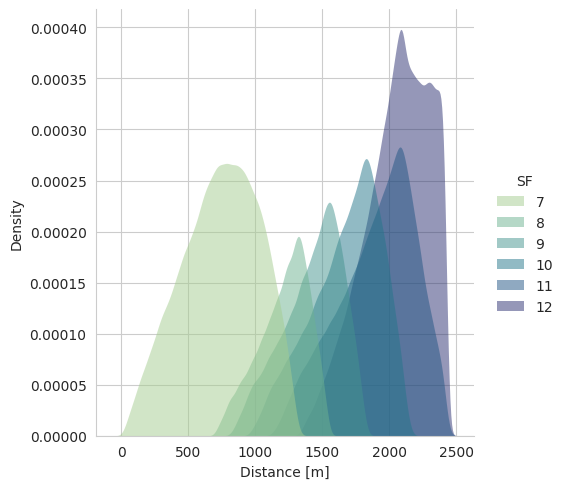

In [9]:
fileformat = 'pdf'
plots_dir = 'plots'
filename = 'SFdistance'

sns.set_style('whitegrid')

sns.displot(data=results, x="Distance [m]", hue="SF", kind="kde",fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
#plt.savefig('{0}/{1}.{2}'.format(plots_dir,filename,fileformat))
plt.show ()